# Brain Tumor Prediction

In [1]:
#import necessary data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2 as cv2
import random
from PIL import Image, ImageOps, ImageEnhance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
print(os.getcwd())


C:\Users\Acer\Downloads\BrainTumorPrediction\api\app\prediction


## Data Visualization

In [5]:
# List images in 'notumor', 'glioma', 'meningioma', and 'pituitary' subdirectories
train_dir = './Training/'
test_dir= './Testing/'


num_train_images = sum([len(files) for _, _, files in os.walk(train_dir)])
num_test_images = sum([len(files) for _, _, files in os.walk(test_dir)])

print(f"Number of images in Training folder: {num_train_images}")
print(f"Number of images in Testing folder: {num_test_images}")

Number of images in Training folder: 5712
Number of images in Testing folder: 1311


In [7]:
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+"//" +label):
        train_paths.append(train_dir + '//'+label+ '//'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

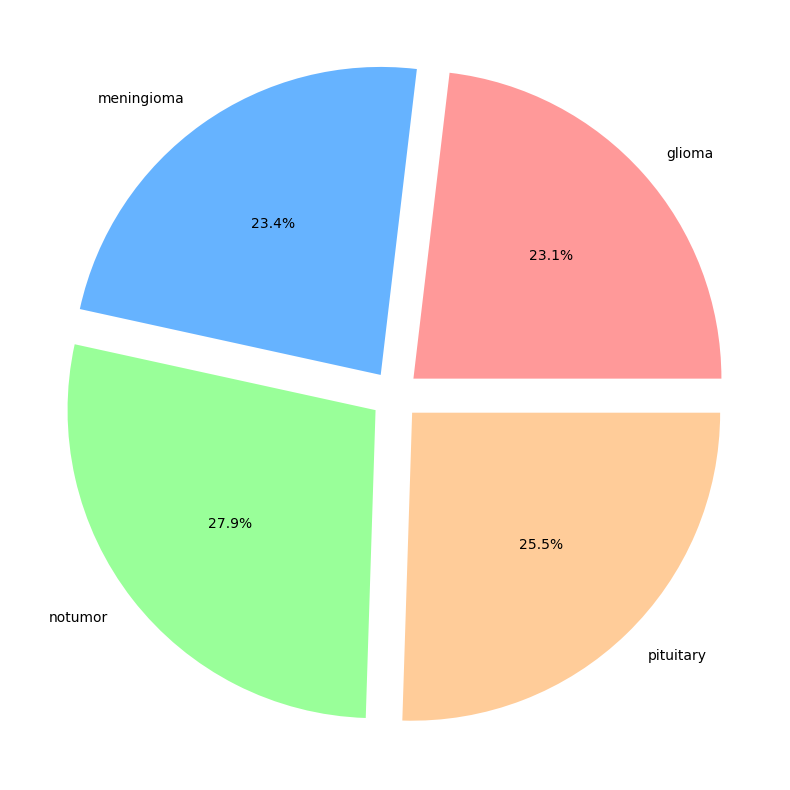

In [9]:
plt.figure(figsize=(10,10))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie([len(os.listdir(train_dir+"//" +label))
        for label in os.listdir(train_dir)],
         labels=os.listdir(train_dir),
          colors = colors,
           explode = (0.08,0.08,0.08,0.08)
           ,autopct='%1.1f%%')
plt.show()

### What are those labels?

- **Notumor**: Indicates that those images do not contain a tumor.  
- **Meningioma**: A type of tumor that develops from the membranes that surround the brain and spinal cord.  
- **Glioma**: A type of tumor that develops from glial cells, which are cells that support and protect neurons.  
- **Pituitary Tumor**: A type of tumor that develops from the pituitary gland, which is located at the base of the brain.
brain

In [12]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+ '//' + label):
        test_paths.append(test_dir +'//'+label + '//'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

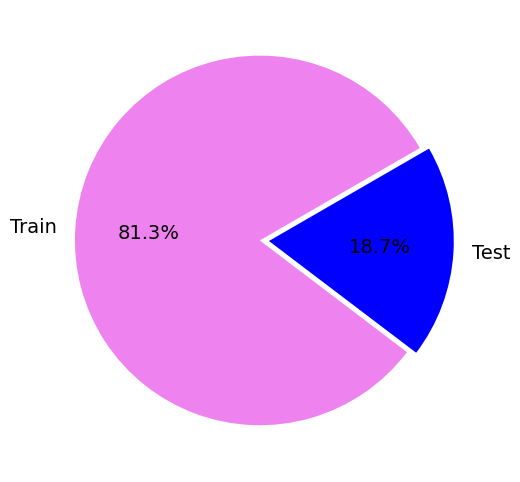

In [14]:
plt.figure(figsize=(14,6))
colors = ['Violet' , 'Blue']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

# Data Preprocessing

In [16]:
from PIL import Image
import os

def process_image(image_path, target_size=(224, 224)):
    try:
        with Image.open(image_path) as img:
            if img.size != target_size or img.mode != 'RGB':
                img = img.convert('RGB')
                img = img.resize(target_size)

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

def process_images_in_directory(directory, target_size=(224, 224)):
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, filename)
                process_image(file_path, target_size)

process_images_in_directory('./Training/', target_size=(224, 224))
process_images_in_directory('./Testing/', target_size=(224, 224))


# Data Augmentation

In [21]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1/255)
train_generator=train_datagen.flow_from_directory('./Training/',
                                                  target_size=(224,224), color_mode='rgb', shuffle=True,
                                                  subset='training', batch_size=32, class_mode='categorical')

test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/NewDataset/Testing/',
                                                  target_size=(224,224), color_mode='rgb', shuffle=True,
                                                   batch_size=32, class_mode='categorical')

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/NewDataset/Training/'

In [11]:
from PIL import Image
import os
import numpy as np

categories = ['notumor', 'glioma', 'meningioma', 'pituitary']

def get_image_shape(image_path):
    with Image.open(image_path) as img:
        img = img.convert('RGB')
        img_array = np.array(img)
        return img_array.shape

def print_image_shapes_and_counts(directory, categories):
    total_images = 0

    for subfolder in categories:
        subfolder_path = os.path.join(directory, subfolder)
        image_files = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        num_images = len(image_files)
        total_images += num_images

        if image_files:
            sample_image_path = os.path.join(subfolder_path, image_files[0])
            sample_image_shape = get_image_shape(sample_image_path)
        else:
            sample_image_shape = (0, 0, 0)

        print(f"\nCategory: {subfolder}")
        print(f"Number of images: {num_images}")
        print(f"Shape of images: {sample_image_shape}")

    print(f"\nTotal number of images in {directory}: {total_images}")

# Print shapes and counts for training and testing directories
print("Printing shapes of images in training directory...")
print_image_shapes_and_counts(train_dir, categories)

print("Printing shapes of images in testing directory...")
print_image_shapes_and_counts(test_dir, categories)


Printing shapes of images in training directory...

Category: notumor
Number of images: 1615
Shape of images: (224, 224, 3)

Category: glioma
Number of images: 1321
Shape of images: (224, 224, 3)

Category: meningioma
Number of images: 1359
Shape of images: (224, 224, 3)

Category: pituitary
Number of images: 1477
Shape of images: (224, 224, 3)

Total number of images in /content/drive/MyDrive/NewDataset/Training/: 5772
Printing shapes of images in testing directory...

Category: notumor
Number of images: 405
Shape of images: (224, 224, 3)

Category: glioma
Number of images: 300
Shape of images: (224, 224, 3)

Category: meningioma
Number of images: 306
Shape of images: (224, 224, 3)

Category: pituitary
Number of images: 310
Shape of images: (224, 224, 3)

Total number of images in /content/drive/MyDrive/NewDataset/Testing/: 1321


In [ ]:
from PIL import UnidentifiedImageError
# Load a fixed number of images from each category
images = []
labels = []

for category in categories:
    category_path = os.path.join(train_dir, category)
    for img_name in os.listdir(category_path)[:4]:
        img_path = os.path.join(category_path, img_name)
        try:
            img = load_img(img_path)
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(category)
        except UnidentifiedImageError:
            print(f"Skipping file {img_name} as it is not a valid image.")

plt.figure(figsize=(15, 15))
for i in range(len(images)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i], color='black', fontsize=16, fontweight='bold')
    plt.axis('off')
plt.show()


### Converting string to categorical

In [20]:
from sklearn.preprocessing import LabelEncoder

# Define the list of labels
labels = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Fit and transform the labels to numeric values
encoded_labels = encoder.fit_transform(labels)

# Create a mapping of numeric indices to labels
label_mapping = {index: label for index, label in enumerate(encoder.classes_)}

# Print the label mapping
print("Label Mapping:", label_mapping)


Label Mapping: {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


# Model Building